# Characterization of corpus callosum DWI using autoencoder

## Abstract

Corpus Callosum (CC) is a subcortical, white matter structure with great importance in clinical and research studies because its shape and volume are correlated with subject's characteristics and neurodegenerative diseases. CC segmentation is a important step for any medical, clinical or research posterior study. Currently, magnetic resonance imaging (MRI) is the main tool for evaluating brain because it offers the better soft tissue contrast. Particullary, segmentation in MRI difussion modality has great importante given information associated to brain microstruture and fiber composition.

In this work a method for characterization of the CC using a autoencoder (AE) is proposed.

In [1]:
## Functions

import sys,os
import copy
main_path = '/home/wilomaku/Repositories/functions/'
paths = [os.path.abspath(main_path), os.path.abspath('{}dtimp'.format(main_path))]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

import numpy as np
import dtimp as DTI
import scipy as scipy
import scipy.misc as misc 
import nibabel as ni
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from numpy import genfromtxt
import platform

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
%matplotlib inline

print("Python version: ", platform.python_version())
print("Numpy version: ", np.version.version)
print("Scipy version: ", scipy.__version__)
print("Matplotlib version: ", mpl.__version__)
print("Pytorch version: ", torch.__version__)

/home/wilomaku/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


Python version:  3.6.3
Numpy version:  1.13.3
Scipy version:  0.19.1
Matplotlib version:  2.1.0
Pytorch version:  0.2.0_4


# Creating dataloader

1 torch.Size([33, 70, 256]) 1.0
2 torch.Size([33, 70, 256]) 1.0
3 torch.Size([33, 70, 256]) 1.0


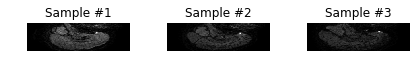

In [2]:
class MRIDataset(Dataset):
    
    def __init__(self, root_dir, n_slice=-1, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            n_slice (int): Slice number. If -1, mid slice is passed.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.n_slice = n_slice
        self.transform = transform

    def __len__(self):
        return len(next(os.walk(self.root_dir))[1])

    def __getitem__(self, idx):
        base_path = '{}{:06.0f}/'.format(self.root_dir,idx+1)
        file_DTI = '{}diffusion.nii.gz'.format(base_path)
        vol_dti = ni.load(file_DTI).get_data()
        
        if self.n_slice == -1:
            slice_ch = int(vol_dti.shape[0]/2)
            vol_2d = vol_dti[slice_ch]
        else:
            vol_2d = vol_dti[self.n_slice]
        
        if self.transform:
            vol_2d = self.transform(vol_2d)
        
        return vol_2d

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample.swapaxes(0,-1)
        return torch.Tensor(image).type(torch.FloatTensor)

class ToNormalize(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample/torch.max(sample)
        return torch.Tensor(image).type(torch.FloatTensor)

base_path = '/home/wilomaku/Documents/ex_anom/'
grad_ch = 15

transformed_dataset = MRIDataset(root_dir=base_path, transform=transforms.Compose([ToTensor(), ToNormalize()]))
fig = plt.figure()
for i in range(1,10):
    sample = transformed_dataset[i]
    print(i,sample.size(),torch.max(sample))
    ax = plt.subplot(1, 3, i)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample.numpy()[grad_ch],cmap='gray')

    if i == 3:
        plt.show()
        break

#Input Channels
Cin = transformed_dataset[i].numpy().shape[0]

In [3]:
dataloader = DataLoader(transformed_dataset, batch_size=2, shuffle=True)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched.size())

0 torch.Size([2, 33, 70, 256])
1 torch.Size([2, 33, 70, 256])
2 torch.Size([2, 33, 70, 256])
3 torch.Size([2, 33, 70, 256])
4 torch.Size([1, 33, 70, 256])


# Autoencoder

In [9]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(Cin, 64, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.mpool1 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.mpool2 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1,0))
        self.mupool2 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv1 = nn.ConvTranspose2d(64, Cin, kernel_size=3, stride=2, padding=1, output_padding=(1,1))
        self.mupool1 = nn.MaxUnpool2d(kernel_size=2, stride=1)

    def encode(self, x):
        h1, self.ind1 = self.mpool1(self.relu(self.conv1(x)))
        h2, self.ind2 = self.mpool2(self.relu(self.conv2(h1)))
        return h2

    def decode(self, y):
        i2 = self.relu(self.deconv2(self.mupool2(y, self.ind2)))
        return self.relu(self.deconv1(self.mupool1(i2, self.ind1)))

    def forward(self, x):
        y = self.encode(x)
        return self.decode(y), y

In [10]:
net = autoencoder()
print(net)

autoencoder (
  (conv1): Conv2d(33, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU ()
  (mpool1): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
  (mupool2): MaxUnpool2d (size=(2, 2), stride=(1, 1), padding=(0, 0))
  (deconv1): ConvTranspose2d(64, 33, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (mupool1): MaxUnpool2d (size=(2, 2), stride=(1, 1), padding=(0, 0))
)


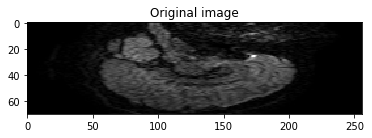

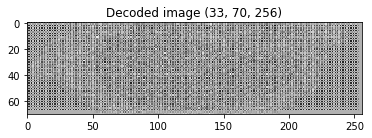

In [25]:
plt.imshow(vol_2d[:,:,15].swapaxes(0,-1), cmap = 'gray')
plt.title('Original image')
plt.show()

pred_out = predict.data.numpy()[0]
plt.imshow(pred_out[15,:,:], cmap = 'gray')
plt.title('Decoded image %s'%str(pred_out.shape))
plt.show()

In [7]:
print('Input >> ',vol_input.shape,vol_input.type())
predict, encode = net(Variable(vol_input))
print('--------------------------------------')
print('Encoded Output >> ',encode.data.shape,encode.data.type())
print('Decoded Output >> ',predict.data.shape,predict.data.type())

Input >>  torch.Size([1, 33, 70, 256]) torch.FloatTensor
--------------------------------------
Encoded Output >>  torch.Size([1, 128, 16, 63]) torch.FloatTensor
Decoded Output >>  torch.Size([1, 33, 70, 256]) torch.FloatTensor


# Training autoencoder

In [8]:
def train(model,train_loader,valid_loader,loss_fn,optimizer,epochs=10,num_break=5,patience=5,criteria_stop="loss"):
    hist_train_loss = hist_val_loss = hist_train_acc = hist_val_acc = np.array([])
    best_epoch = patience_count = 0

    print("Training starts along %i epoch"%epochs)
    for e in range(epochs):
        correct_train = correct_val = total_train = total_val = 0
        cont_i = loss_t_e = loss_v_e = 0
        for data_train, data_valid in zip(train_loader, valid_loader):
            #if cont_i == num_break:
            #    break

            inputs = data_train
            var_inputs = Variable(inputs)

            predict, encode = model(var_inputs)
            loss = loss_fn(predict, var_inputs)
            loss_t_e += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ##Validating model
            inputs = data_valid
            var_inputs = Variable(inputs)
            predict, encode = model(var_inputs)
            loss_val = loss_fn(predict, var_inputs)
            loss_v_e += loss_val.data[0]

            cont_i += 1

        #Stacking historical
        hist_train_loss = np.hstack((hist_train_loss, loss_t_e/(cont_i*1.0)))
        hist_val_loss = np.hstack((hist_val_loss, loss_v_e/(cont_i*1.0)))
        #if e%10 == 0:
        print('Epoch: ', e, 'train loss: ', hist_train_loss[-1], 'valid loss: ', hist_val_loss[-1])

        #Early stopping by best accuracy or best loss
        if(criteria_stop == "acc"):
            if(hist_val_acc[best_epoch] < hist_val_acc[-1]):
                patience_count = 0
                best_epoch = e
                best_model = copy.copy(model)
        else:
            if(hist_val_loss[best_epoch] > hist_val_loss[-1]):
                patience_count = 0
                best_epoch = e
                best_model = copy.copy(model)

        if(patience_count > patience):
            print("Early stopped")
            break;

        if(e == epochs-1):
            print("Training stopped")
        patience_count += 1

    return(best_model, hist_train_loss, hist_val_loss)

In [11]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
epochs = 10
patience = 5
max_batch = 2
criteria = "loss"

best_model, loss, loss_test = train(net, dataloader, dataloader, loss_fn, optimizer, epochs = epochs, 
                                     num_break = max_batch, patience = patience, criteria_stop = criteria)

Training starts along 10 epoch
Epoch:  0 train loss:  0.00140545717441 valid loss:  0.00143417906947
Epoch:  1 train loss:  0.00136153767817 valid loss:  0.0013405237929
Epoch:  2 train loss:  0.00135046381038 valid loss:  0.00126400545705
Epoch:  3 train loss:  0.00120859928429 valid loss:  0.00113581265323
Epoch:  4 train loss:  0.00104169272818 valid loss:  0.00100815597689
Epoch:  5 train loss:  0.00088333558524 valid loss:  0.000917121430393
Epoch:  6 train loss:  0.000743295333814 valid loss:  0.00074158271309
Epoch:  7 train loss:  0.000636667694198 valid loss:  0.000605262682075
Epoch:  8 train loss:  0.000507586286403 valid loss:  0.000517492042854
Epoch:  9 train loss:  0.00042418455123 valid loss:  0.000427314906847
Training stopped


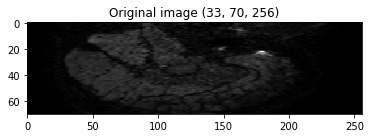

Decod >  torch.Size([1, 33, 70, 256]) Encod >  torch.Size([1, 128, 16, 63])


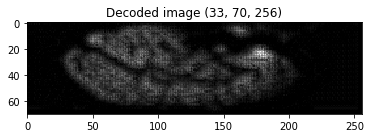

In [20]:
dataloader_val = DataLoader(transformed_dataset, batch_size=1, shuffle=True)

for n_i, sample_batched in enumerate(dataloader_val):
    or_out = sample_batched.numpy()[0]
    plt.imshow(or_out[15,:,:], cmap = 'gray')
    plt.title('Original image %s'%str(or_out.shape))
    plt.show()
    #######################################################
    dec_out, enc_out = best_model(Variable(sample_batched))
    print('Decod > ', dec_out.size(), 'Encod > ', enc_out.size())
    pred_out = dec_out.data.numpy()[0]
    plt.imshow(pred_out[15,:,:], cmap = 'gray')
    plt.title('Decoded image %s'%str(pred_out.shape))
    plt.show()
    if n_i == 0:
        break

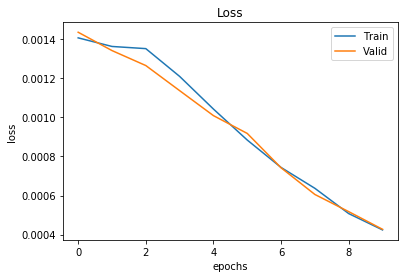

In [18]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(loss, label='Train')
plt.plot(loss_test, label='Valid')
plt.legend()
plt.show()